In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mne import set_log_level
from mne.io import read_raw_eeglab

from pycrostates.cluster import ModKMeans
from pycrostates.datasets import lemon


set_log_level("ERROR")  # reduce verbosity

raw_fname = lemon.data_path(subject_id="010017", condition="EO")
raw = read_raw_eeglab(raw_fname, preload=True)
raw.crop(0, 180)
raw.pick("eeg")
raw.set_eeg_reference("average")

<RawEEGLAB | sub-010017_EO.fdt, 61 x 45001 (180.0 s), ~21.0 MB, data loaded>

In [90]:
from pycrostates.preprocessing import extract_gfp_peaks


cluster_numbers = [2,3,4,5,6]

gfp_peaks = extract_gfp_peaks(raw)

gevs = list()
image_files=list()
labels = []
maps = list()
ModKs = list()
for k, n_clusters in enumerate(cluster_numbers):
    # fit K-means algorithm with a set number of cluster centers
    ModK = ModKMeans(n_clusters=n_clusters, random_state=42)
    ModK.fit(gfp_peaks, n_jobs=6, verbose="WARNING")
    gevs.append(ModK.GEV_)
    labels.append(ModK._labels_)
    maps.append(ModK._cluster_centers_)
    fig = ModK.plot(show=False)
    image = f'cluster_centers_{k}.png'
    ModKs.append(ModK)
    fig.savefig(image)   # save the figure to file
    plt.close(fig) 
    image_files.append(image)

<Axes: >

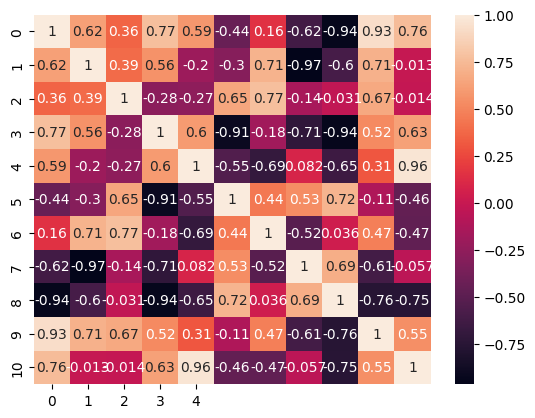

In [39]:
import seaborn

seaborn.heatmap(np.corrcoef(arr1, arr2), annot=True)

<Axes: >

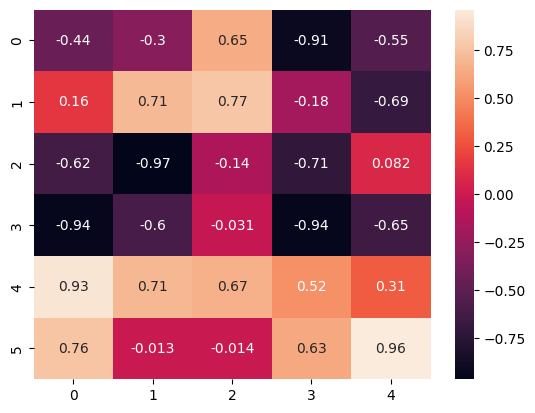

In [43]:
seaborn.heatmap(np.corrcoef(arr1, arr2)[len(arr1):, :len(arr2)-1], annot=True, xticklabels=np.arange(len(arr1)),  yticklabels=np.arange(len(arr2)))

In [80]:
arr2.shape

(6, 61)

In [87]:
maps_

[array([[-0.16909225, -0.18168627, -0.13185946, -0.10200007, -0.12708302,
         -0.16239071, -0.18672927, -0.02173245,  0.03333959, -0.05858846,
         -0.14508786, -0.02368188,  0.15770895,  0.07443468, -0.00553853,
         -0.13870798,  0.10446673,  0.20181705,  0.12983919, -0.00067351,
         -0.15941824,  0.04675205,  0.1895597 ,  0.20906807,  0.10780204,
         -0.04559632, -0.02426139,  0.0970656 ,  0.09595131,  0.07233702,
         -0.07410072, -0.15343109, -0.14283958, -0.17349149, -0.18888728,
         -0.1061003 , -0.08939634, -0.13889783, -0.18535639, -0.05440564,
          0.0355006 , -0.09090017, -0.16424148,  0.05314855,  0.15496661,
          0.05947304, -0.08790236,  0.0084496 ,  0.18532027,  0.17209759,
          0.06882285, -0.10480043,  0.12997054,  0.21027881,  0.16328947,
          0.02935329,  0.09554651,  0.19434112,  0.20357392,  0.14311206,
          0.01149193],
        [-0.00114746, -0.04210105,  0.06037707,  0.08061233,  0.005731  ,
         -0.091

In [101]:
[x.n_clusters for x in ModKs_[1:]]

[5, 4, 3, 2]

In [128]:
arr1.shape

(4, 61)

(6, 61) (5, 61) (6, 5)
[1 2 3 4 5] [2 1 3 0 4]
(6, 61) (4, 61) (6, 4)
[0 1 3 4] [1 2 3 0]
(6, 61) (3, 61) (6, 3)
[0 1 4] [1 0 2]
(6, 61) (2, 61) (6, 2)
[3 4] [0 1]


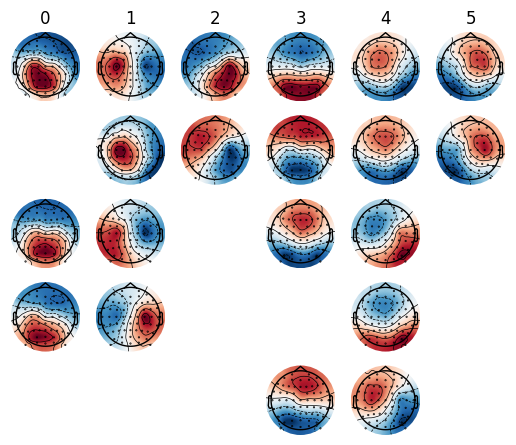

In [144]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import mne

ModKs_ = ModKs.copy()
ModKs_.reverse()

# Create a figure and subplots
fig, axes = plt.subplots(nrows=len(ModKs_), ncols=ModKs_[0].n_clusters)
ModKs_[0].plot(axes=axes[0, :], show=False)
for i, ModK in enumerate(ModKs_[:-1]):
    arr2 = ModKs_[0].cluster_centers_
    arr1 = ModKs_[i+1].cluster_centers_
    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(arr1, arr2)[len(arr1):, :len(arr1)]
    # Negate the correlation matrix to convert the maximization problem to a minimization problem
    cost_matrix = np.abs(correlation_matrix)

    print(arr2.shape, arr1.shape, cost_matrix.shape)
    # Solve the linear assignment problem using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    print(row_ind, col_ind)
    # Reorder the arrays based on the optimal assignment
    for row, col in zip(row_ind, col_ind):
        data = arr1[col]
        mne.viz.plot_topomap(data, ModKs_[0].info, axes=axes[i+1,row], show=False)
for ax in axes.flat:
    ax.axis('off')
plt.show()


[[0.94640008 0.29662685]
 [0.02946009 0.85179273]
 [0.87918395 0.77469733]]
[0. 1. 2.]
[[0.40558633 0.78117045 0.85032942]
 [0.96315708 0.17286447 0.65133682]
 [0.57352103 0.82697857 0.19593777]
 [0.80146953 0.09898999 0.9657238 ]]
[1. 2. 3. 0.]
[[0.65475709 0.25462555 0.9790391  0.81611048]
 [0.56631874 0.48980366 0.48799551 0.92706224]
 [0.38419951 0.53607027 0.19725521 0.59778709]
 [0.98308407 0.42426237 0.82170728 0.54735853]
 [0.49029972 0.92913125 0.73165325 0.01324619]]
[3. 4. 0. 1. 2.]
[[0.90628451 0.54664591 0.43892435 0.30460692 0.65121647]
 [0.1805938  0.68988119 0.15537729 0.70878301 0.7697947 ]
 [0.71439112 0.08176589 0.62157791 0.96559396 0.14427143]
 [0.94096974 0.64791878 0.93855823 0.60259688 0.03090673]
 [0.51873394 0.30518074 0.92697029 0.70541335 0.66855307]
 [0.62959643 0.9619632  0.75989902 0.01278631 0.0140607 ]]
[3. 5. 4. 2. 1. 0.]


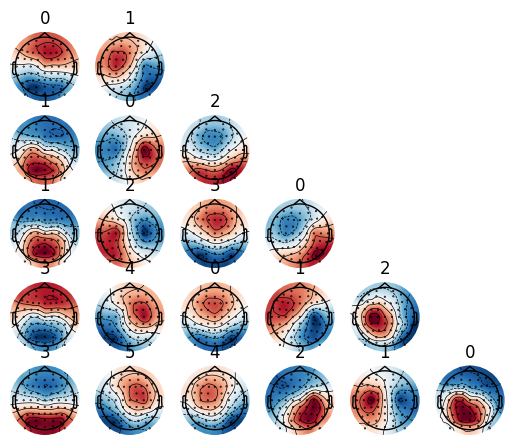

In [187]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import mne

ModKs_ = ModKs.copy()

# Create a figure and subplots
fig, axes = plt.subplots(nrows=len(ModKs_), ncols=ModKs_[-1].n_clusters)

ModKs_[0].plot(axes=axes[0, :ModKs_[0].n_clusters], show=False)

for i, ModK in enumerate(ModKs_[:-1]):
    template = ModKs_[i].cluster_centers_
    current = ModKs_[i+1].cluster_centers_
    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(template, current)[len(template):, :len(template)]
    # Negate the correlation matrix to convert the maximization problem to a minimization problem
    cost_matrix = np.abs(correlation_matrix)
    print(cost_matrix)
    new_order = np.empty((len(current)))
    p = 0
    while p < len(template):
        ind = np.unravel_index(np.argmax(cost_matrix, axis=None), cost_matrix.shape)
        new_order[ind[1]] = ind[0]
        # Remove the second row (index 1)
        cost_matrix[ind[0], :] = 0
        cost_matrix[:, ind[1]] = 0
        p += 1
    new_order[-1] = list(set(np.arange(len(current))) - set(np.unique(new_order)))[0]
    print(new_order)
    tmp = ModKs_[i+1]
    tmp.reorder_clusters(order=new_order.astype(int))
    tmp.plot(axes=axes[i+1, :ModKs_[i+1].n_clusters], show=False)

for ax in axes.flat:
    ax.axis('off')
plt.show()


In [183]:
new_order[-1]

2.0

In [33]:
from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColorBar, ColumnDataSource, HoverTool, Select, CustomJS
from bokeh.palettes import Viridis256
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
import umap

mapper = umap.UMAP().fit(ModK.fitted_data.T)

# Assuming you have the following data columns: x, y, z0, z1, z2
data = {
    'x': mapper.embedding_[:, 0],
    'y': mapper.embedding_[:, 1],
}

color_columns = list()
for k, label in zip(cluster_numbers, labels):
    column_name = f'k_{k}'
    data[column_name] = label
    color_columns.append(column_name)

# Create a ColumnDataSource
source = ColumnDataSource(data=data)

# Create a Select widget for interactive column switching
select = Select(title='Select K Column', options=color_columns, value=color_columns[0])

# Define the color mapper based on the selected column
color_mapper = linear_cmap(field_name=select.value, palette=Viridis256, low=0, high=6)

# Create the scatter plot
plot = figure()
scatter = plot.circle('x', 'y', source=source, fill_color=color_mapper, line_color='black', size=10)

# Add a color bar to show the color mapping
color_bar = ColorBar(color_mapper=color_mapper['transform'], label_standoff=12)
plot.add_layout(color_bar, 'right')

# Add a hover tool to display data on hover
hover_tool = HoverTool(tooltips=[('x', '@x'), ('y', '@y'), (select.value, f'@{select.value}')])
plot.add_tools(hover_tool)

# JavaScript callback function
callback = CustomJS(args=dict(source=source, color_mapper=color_mapper, hover_tool=hover_tool, scatter=scatter, select=select), code="""
    const data = source.data;
    const value = select.value;
    const colorMapper = color_mapper['transform'];

    // Update color mapper field
    colorMapper.field_name = value;

    // Update the fill color property of the scatter glyph
    scatter.glyph.fill_color = {field: value, transform: colorMapper};

    source.change.emit();
""")

# Attach the JavaScript callback to the Select widget
select.js_on_change('value', callback)

# Create a column layout with the Select widget above the plot
layout = column(select, plot)

# Show the layout
show(layout)